# Gaussian mixture models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
sns.set()  # Default seaborn theme, scaling & color palette

## Create some data

In [2]:
clusters = 3
n_cluster = [90, 50, 75]
n_total = sum(n_cluster)
means = [9, 21, 35]
std_devs = [2, 2, 2]

mix = np.random.normal(np.repeat(means, n_cluster), np.repeat(std_devs, n_cluster))
# sns.kdeplot(np.array(mix))
# plt.xlabel('$x$', fontsize=14)
# plt.show()
# plt.close()

## Create a mixture model & sample

In [3]:
model = pm.Model()
with model:

    p = pm.Dirichlet('p', a=np.ones(clusters))  # Probabilities of data coming from each cluster
    category = pm.Categorical('category', p=p, shape=n_total)  # Use above probs to form a distribution

    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)  # means of each gaussian (different)
    sd = pm.HalfCauchy('sd', 5)  # sd of each gaussian (the same)

    y = pm.Normal('y', mu=means[category], sd=sd, observed=mix)  # Gaussian likelihood, sd assumed known

In [4]:
with model:
    step1 = pm.ElemwiseCategorical(vars=[category], values=range(clusters))  # Sample which Gaussian distribution
    step2 = pm.Metropolis(vars=[p])  #
    trace_kg = pm.sample(10000, step=[step1, step2])

/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>ElemwiseCategorical: [category]
>Metropolis: [p]
>NUTS: [sd, means]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:26<00:00, 487.07draws/s]
The number of effective samples is smaller than 25% for some parameters.


/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/s

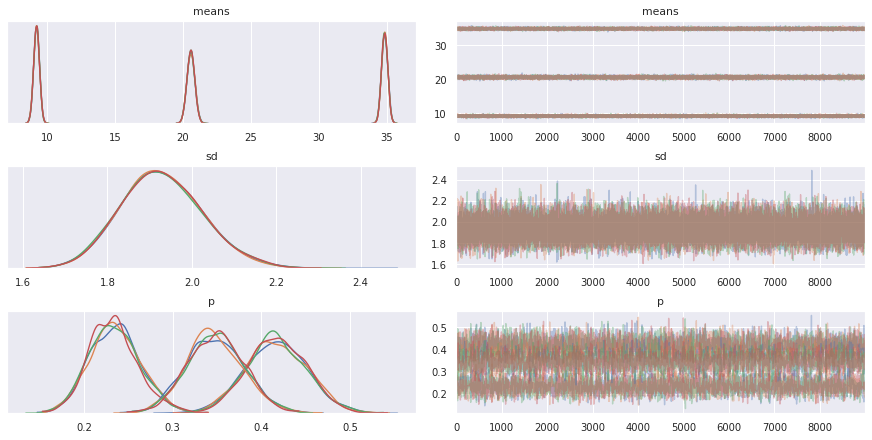

In [5]:
chain = trace_kg[1000:]
varnames = ['means', 'sd', 'p']
pm.traceplot(chain, varnames)
plt.show()
plt.close()

## Predict from the model

/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 50/50 [00:01<00:00, 40.24it/s]


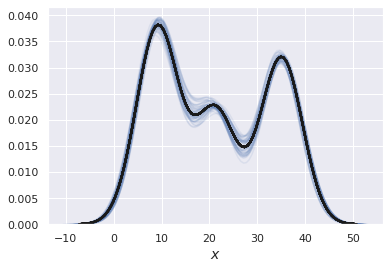

In [6]:
ppc = pm.sample_ppc(chain, 50, model)
for i in ppc['y']:
    sns.kdeplot(i, alpha=0.1, color='b')
    sns.kdeplot(np.array(mix), lw=2, color='k')
    plt.xlabel('$x$', fontsize=14)

## Marginalized mixture model

Don't specify latent variable - which Gaussian the data originates from.

In [8]:
model_mg = pm.Model()
with model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))  # probability of data coming from each cluster
    
    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)  # Means of each gaussian
    sd = pm.HalfCauchy('sd', 5, shape=clusters)  # Sd of each gaussian
    
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=mix)  # marginalized gaussian mixture likelihood
    
    step = pm.Metropolis()
    trace_mg = pm.sample(2000, step)

INFO (theano.gof.compilelock): Refreshing lock /home/sean/.theano/compiledir_Linux-5.3--generic-x86_64-with-debian-buster-sid-x86_64-3.7.7-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [means]
>Metropolis: [p]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:03<00:00, 3004.32draws/s]
The number of effective samples is smaller than 10% for some parameters.


/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/s

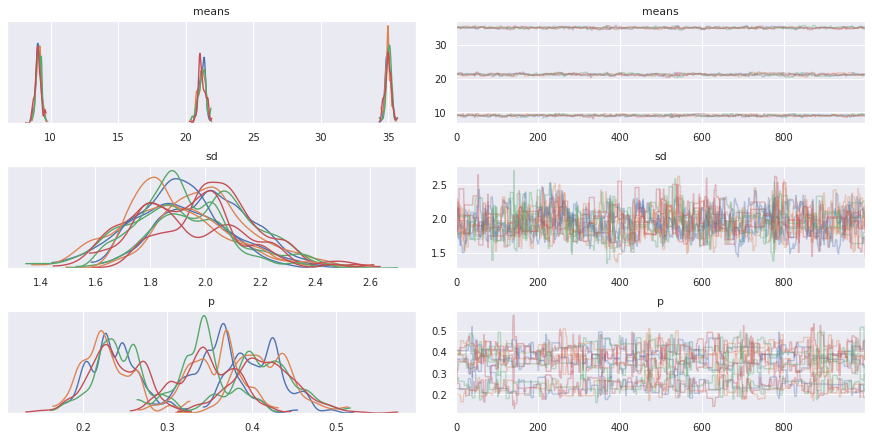

In [9]:
with model_mg:
    chain = trace_mg[1000:]
    varnames = ['means', 'sd', 'p']
    pm.traceplot(chain, varnames)
    plt.show()
    plt.close()

/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 50/50 [00:01<00:00, 30.18it/s]


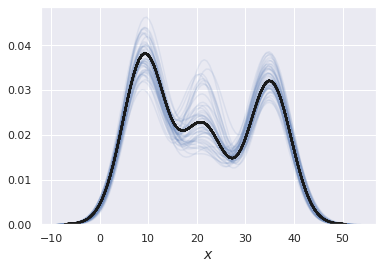

In [10]:
ppc = pm.sample_ppc(chain, 50, model_mg)
for i in ppc['y']:
    sns.kdeplot(i, alpha=0.1, color='b')
    sns.kdeplot(np.array(mix), lw=2, color='k')
    plt.xlabel('$x$', fontsize=14)